[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1UjkD-oXeWeYffi8j9EIy4rMYrFl1vQXS?usp=sharing)

# Neural style transfer


## Introduction


Style transfer consists in generating an image merging a **"content"(C)** image with a **"style"(S)** image to create a **"generated"(G)** image. The generated image G combines the "content" of the image C with the "style" of image S (generally artistic).


This is achieved through the optimization of a loss function
that has 3 components: "style loss", "content loss",
and "total variation loss":

- **Total variation loss**: Imposes local spatial continuity between
the pixels of the combination image, giving it visual coherence.
- **Style loss**: is where the deep learning keeps in --that one is defined
using a deep convolutional neural network. Precisely, it consists in a sum of
L2 distances between the Gram matrices of the representations of
the base image and the style reference image, extracted from
different layers of a convnet (trained on ImageNet). The general idea
is to capture color/texture information at different spatial
scales (fairly large scales --defined by the depth of the layer considered).
- **Content loss**: is a L2 distance between the features of the base
image (extracted from a deep layer) and the features of the combination image,
keeping the generated image close enough to the original one.

**References:**
- https://github.com/ezponda/intro_deep_learning/blob/main/class/CNN/Neural_Style_Transfer.ipynb
- [A Neural Algorithm of Artistic Style](
  http://arxiv.org/abs/1508.06576)
- Same notebook as [Chollet](https://keras.io/examples/generative/neural_style_transfer/)
- Course 4, week 4 (convolutional neural networks) of Coursera deep learning specialization, [link](https://www.coursera.org/learn/convolutional-neural-networks?specialization=deep-learning)



It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb)

In [ ]:
## if you have a GPU
GPU=False
#%tensorflow_version 2.x
import tensorflow as tf
if GPU:
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))

## Loading images


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.pyplot as plt
%matplotlib inline

You can download the image with an image url using [get_file](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file)
```python
tf.keras.utils.get_file(
    fname, origin, untar=False, md5_hash=None, file_hash=None,
    cache_subdir='datasets', hash_algorithm='auto',
    extract=False, archive_format='auto', cache_dir=None
)
```

In [ ]:
result_prefix = "paris_generated"

281701/281701 [==============================] - 0s 0us/step


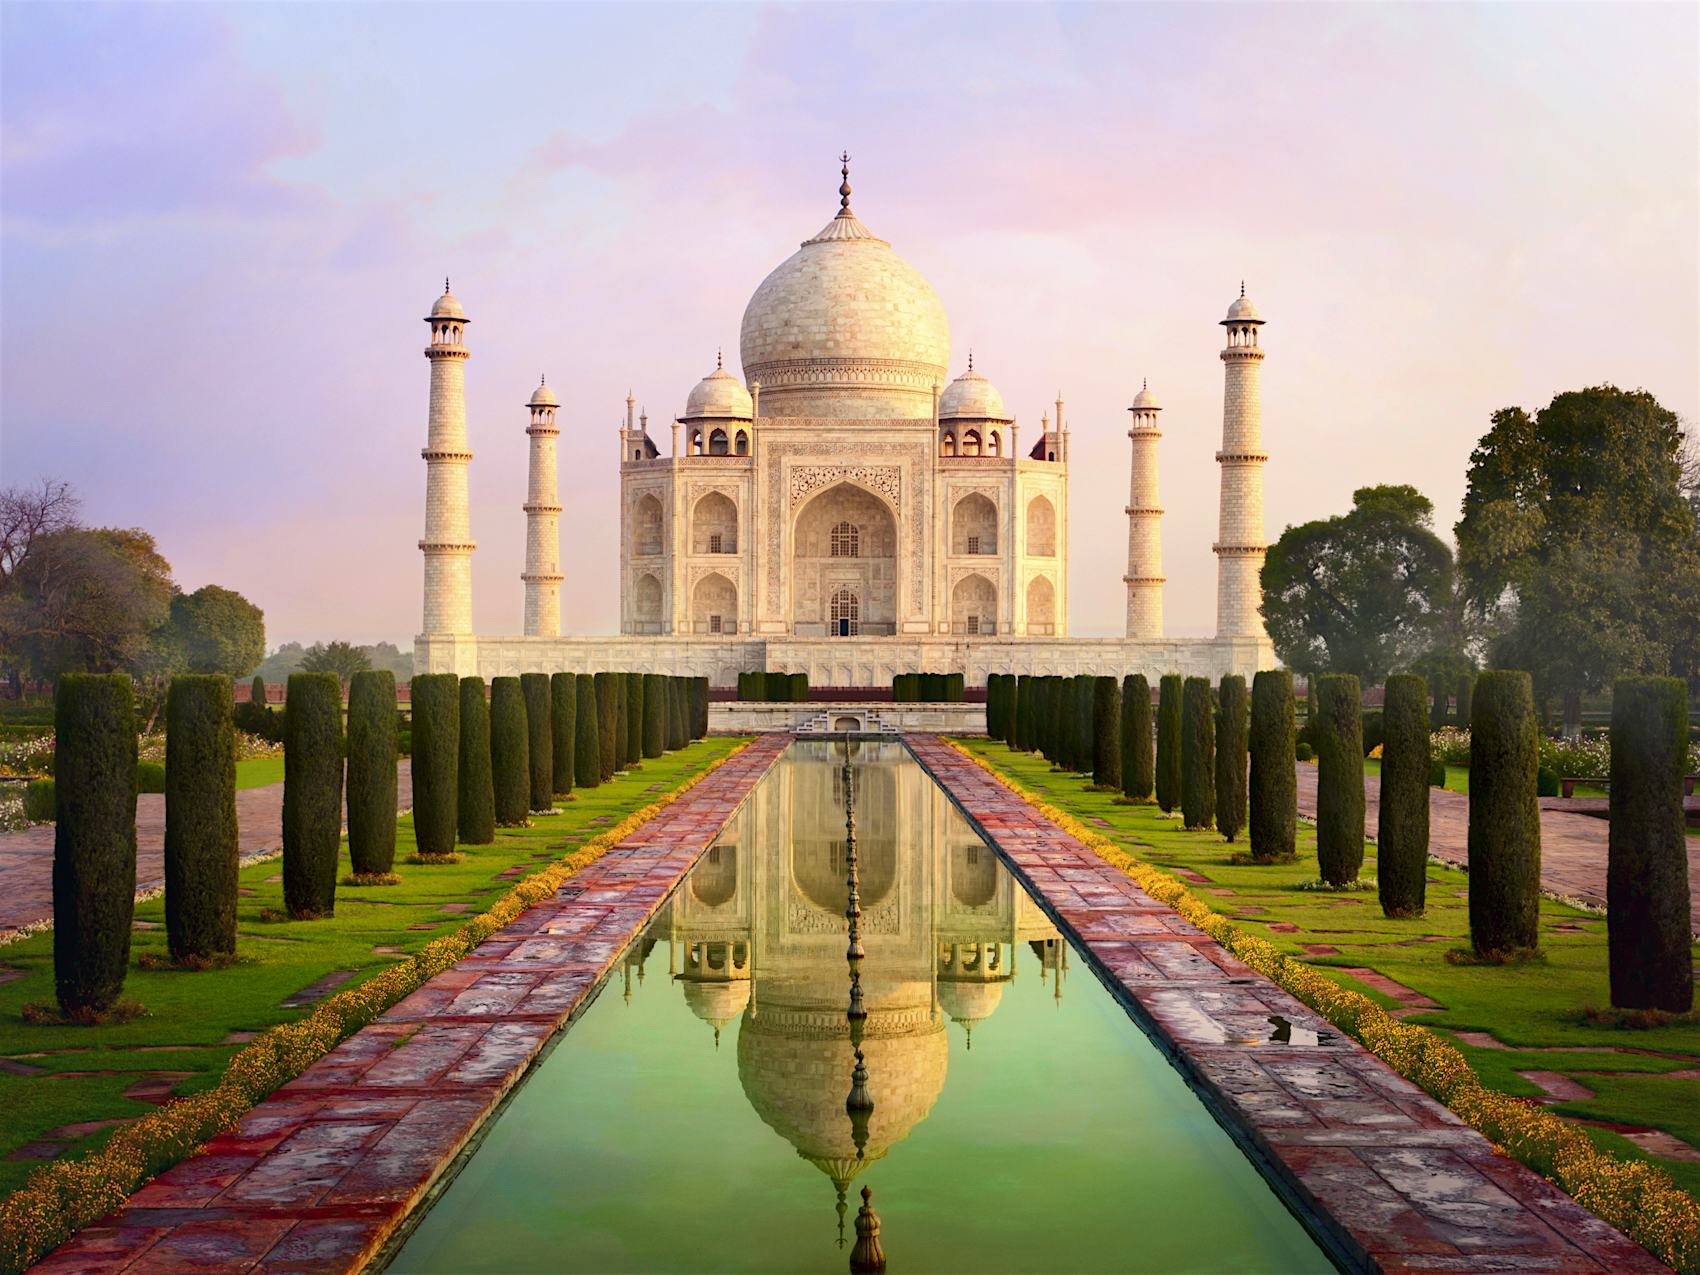

In [ ]:
## Content (C) Image
# url_content = "https://i.imgur.com/F28w3Ac.jpg"
url_content = 'https://lp-cms-production.imgix.net/2020-11/GettyRF_494057771.jpg?auto=format&fit=crop&sharp=10&vib=20&ixlib=react-8.6.4&w=850&q=50&dpr=2'
base_image_path = tf.keras.utils.get_file("paris.jpg", url_content)
display(Image(base_image_path))

131735/131735 [==============================] - 0s 0us/step


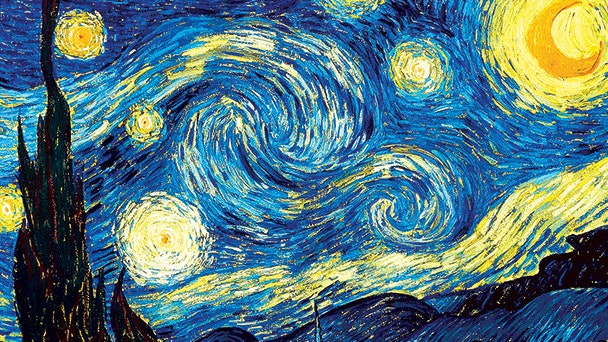

In [ ]:
## Style (S) Image
url_style = 'https://media.admagazine.com/photos/618a7dbc58ac69e38abb6c2c/16:9/w_1280,c_limit/43884.jpg'
style_reference_image_path = keras.utils.get_file(
    "starry_night_2.jpg", url_style)

display(Image(style_reference_image_path))

## Transfer Learning

We are going to use the same pre-trained CNN as in the [original paper](https://arxiv.org/abs/1508.06576) the [VGG-19](https://keras.io/api/applications/vgg/), a 19-layer version of the VGG network trained in ImageNet.



In [ ]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
from tensorflow.keras.applications import vgg19
model = vgg19.VGG19(weights="imagenet", include_top=False)
model.summary()

80134624/80134624 [==============================] - 2s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = {layer.name:layer.output for layer in model.layers}
# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)


We need to define the layers that we are going to use in the NST, you can play with them.

In [ ]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


Lets visualize one feature map for the content image

In [ ]:
img_C = keras.preprocessing.image.load_img(base_image_path)
img_C = tf.keras.preprocessing.image.img_to_array(img_C)
img_C = np.expand_dims(img_C, axis=0)
img_C = tf.keras.applications.vgg19.preprocess_input(img_C)
features = feature_extractor(img_C)
layer_features = features[content_layer_name]
print(layer_features.shape)

(1, 79, 106, 512)


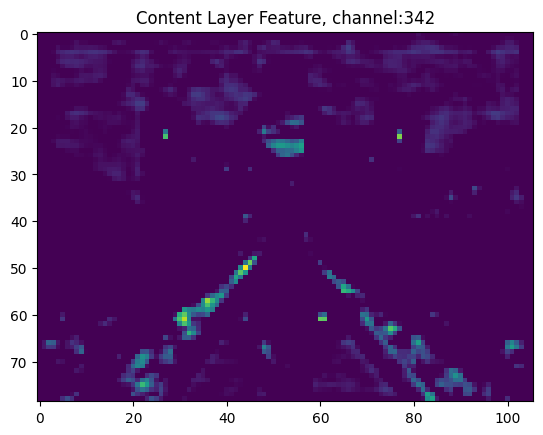

In [ ]:
## features from content layer
ind = np.random.randint(512)
plt.imshow(layer_features[0, :, :, ind], cmap='viridis')
plt.title('Content Layer Feature, channel:{0}'.format(ind))
plt.show()

Same with the style features

block1_conv1


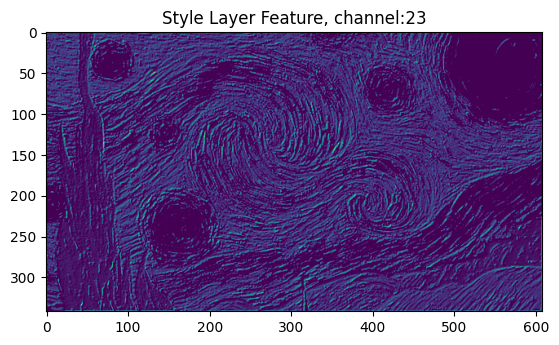

block2_conv1


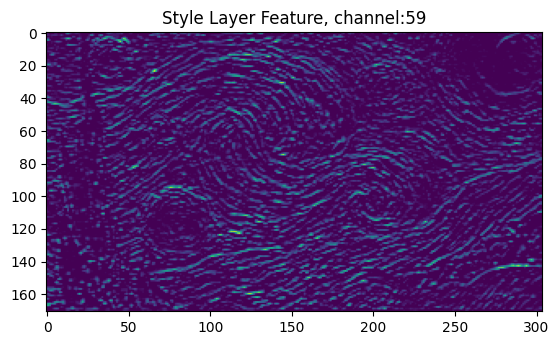

block3_conv1


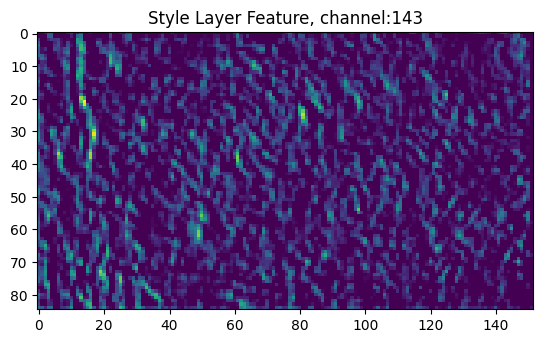

block4_conv1


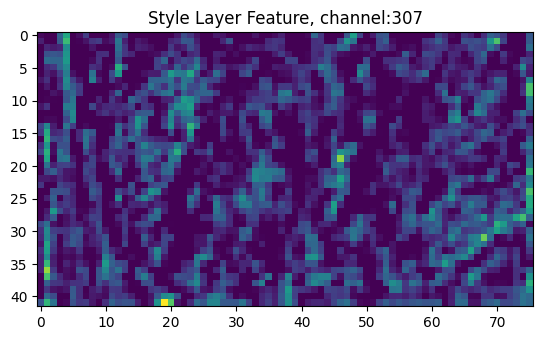

block5_conv1


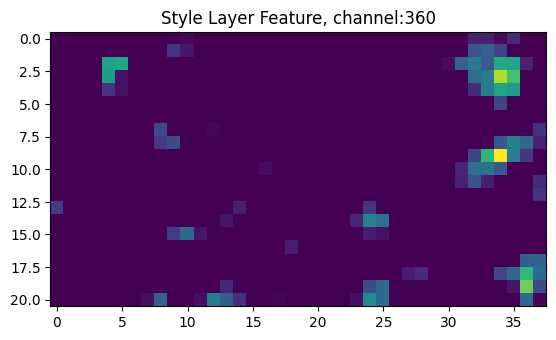

In [ ]:
img_S = keras.preprocessing.image.load_img(style_reference_image_path)
img_S = tf.keras.preprocessing.image.img_to_array(img_S)
img_S = np.expand_dims(img_S, axis=0)
img_S = tf.keras.applications.vgg19.preprocess_input(img_S)
features = feature_extractor(img_S)
for style_layer in style_layer_names:
    print(style_layer)
    layer_features = features[style_layer]
    ind = np.random.randint(layer_features.shape[-1])
    plt.imshow(layer_features[0, :, :, ind], cmap='viridis')
    plt.title('Style Layer Feature, channel:{0}'.format(ind))
    plt.show()


## Image preprocessing / deprocessing utilities


In [ ]:
# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x



## Compute losses functions

First, we need to define 4 utility functions:

- `gram_matrix` (used to compute the style loss)
- The `style_loss` function, which keeps the generated image close to the local textures
of the style reference image
- The `content_loss` function, which keeps the high-level representation of the
generated image close to that of the base image
- The `total_variation_loss` function, a regularization loss which keeps the generated
image locally-coherent


#### Content Cost Function $J_{content}(C,G)$

The content loss is a L2 distance between the features of the base
image (extracted from a deep layer) and the features of the combination image,
keeping the generated image close enough to the original one.

We will define the content cost function as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C} \sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2 $$


In [ ]:
def content_loss(base, combination):
    n_H, n_W, n_C = base.shape
    norm = 4 * n_H * n_W * n_C
    return tf.reduce_sum(tf.square(combination - base)) / norm

### Style Cost Function $J_{style}(S,G)$.

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.


In [ ]:
# The gram matrix of an image tensor (feature-wise outer product)

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    n_H, n_W, n_C = style.shape
    size = n_H *  n_W
    norm = (4.0 * (n_C ** 2) * (size ** 2))
    return tf.reduce_sum(tf.square(S - C)) / norm


### Total Variation Loss $J_{TV}(G)$

$$ J_{TV}(G) = \sum_{i,j} \sqrt{|G_{i+1,j} - G_{i,j}|^2 + |G_{i,j+1} - G_{i,j}|^2} $$

We are going to use a small modification

In [ ]:
# The 3rd loss function, total variation loss,

def total_variation_loss(x):
    return tf.image.total_variation(x)


### Complete loss

$$ J(G) = \lambda_{content} \cdot J_{content}(C,G) + \lambda_{style} \cdot J_{style}(S,G) + \lambda_{TV} \cdot J_{TV}(G) $$

In [ ]:

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8


def compute_loss(combination_image, base_image, style_reference_image,
                 total_variation_weight, style_weight, content_weight):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

@tf.function
def compute_loss_separate(combination_image, base_image, style_reference_image,
                          total_variation_weight, style_weight, content_weight):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Add content loss
    c_loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    c_loss = c_loss +  content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    s_loss = tf.zeros(shape=())
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        s_loss += (1 / len(style_layer_names)) * sl

    tv_loss = tf.zeros(shape=())
    tv_loss = tv_loss + total_variation_loss(combination_image)

    return c_loss, s_loss, tv_loss


## Add a tf.function decorator to loss & gradient computation

To compile it, and thus make it fast.


In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image,
                           total_variation_weight, style_weight, content_weight):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image,
        total_variation_weight, style_weight, content_weight)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

## The training loop

Repeatedly run vanilla gradient descent steps to minimize the loss, and save the
resulting image every 100 iterations.

We decay the learning rate by 0.96 every 100 steps.


In [ ]:
optimizer = tf.keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

total_variation_weight = 1e-6
style_weight = 1e-5
content_weight = 2.5e-6

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image,
        total_variation_weight, style_weight, content_weight
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 5 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        c_loss, s_loss, tv_loss = compute_loss_separate(
            combination_image, base_image, style_reference_image,
            total_variation_weight, style_weight, content_weight)
        print('content_loss={0}, style_loss={1}, tv_loss={2}'.format(c_loss, s_loss, tv_loss))
        print('weighed content_loss={0}, style_loss={1}, tv_loss={2}'.format(
            content_weight * c_loss, style_weight * s_loss, total_variation_weight * tv_loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        #keras.preprocessing.image.save_img(fname, img)
        #display(Image(fname))
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.show()


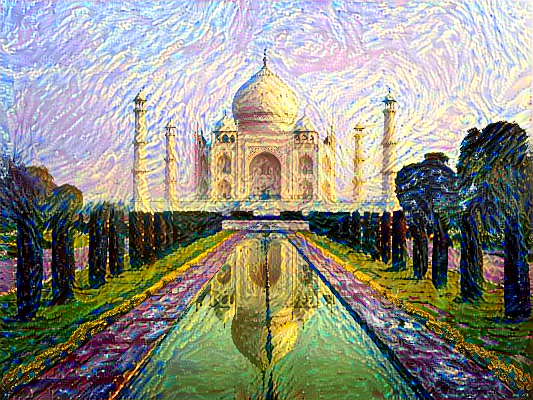

In [ ]:
keras.preprocessing.image.save_img(fname, img)
display(Image(fname))

After 4000 iterations, you get the following result:


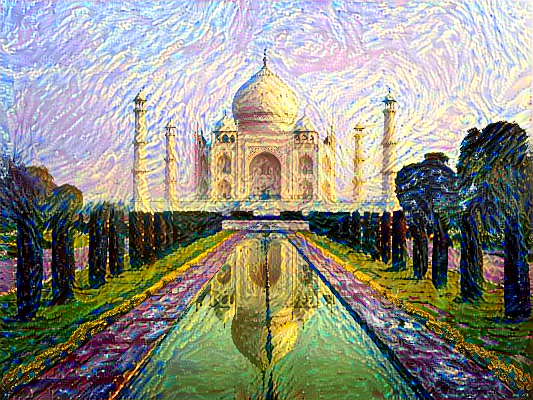

In [ ]:
display(Image(result_prefix + "_at_iteration_4000.png"))

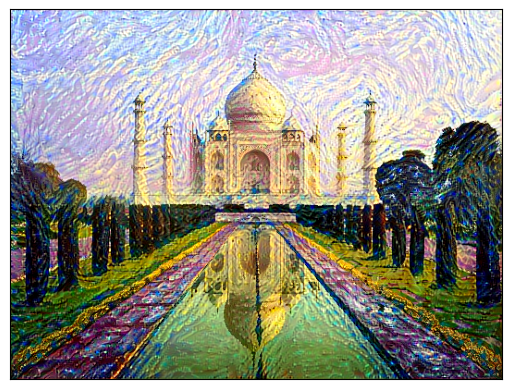

In [ ]:
plt.imshow(img);
plt.xticks([]);
plt.yticks([]);

## Fast Style Transfer using TF-Hub

[Exploring the structure of a real-time, arbitrary neural artistic stylization network](https://arxiv.org/abs/1705.06830) (Ghiasi, Lee, Kudlur, Dumoulin & Shlens,
  2017)

Let's see how the [TensorFlow Hub model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) implements the fast style transfer:

In [ ]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
content_image = img_C.astype(np.float32) / 255.
style_image = img_S.astype(np.float32) / 255.
# Optionally resize the images. It is recommended that the style image is about
# 256 pixels (this size was used when training the style transfer network).
# The content image can be any size.
style_image = tf.image.resize(style_image, (256, 256))
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]

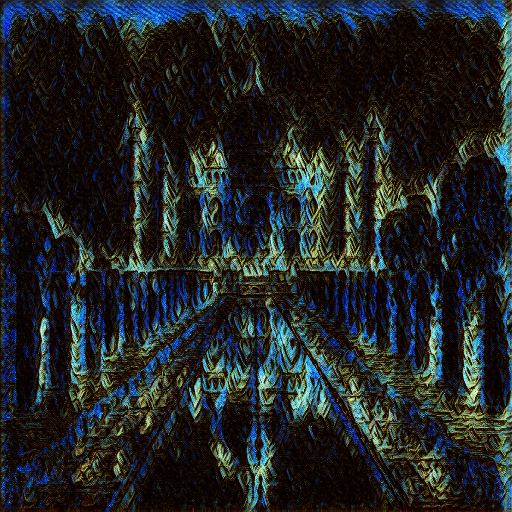

In [ ]:
import PIL.Image
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)
tensor_to_image(tf.image.resize(stylized_image, (512, 512)))